## Emulation of PCA data

This notebook builds an emulator for the data created in the `Create_PCA_datasets`

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
main_path = os.getcwd()
main_path


'/Users/pmzff/Documents/GitHub/ModularCircFF/Emulation'

In [3]:
# Read Data
df_x = pd.read_csv(f'{main_path}/Input/input_100.csv')

pressure_traces = pd.read_csv(f'{main_path}/Outputs/Out_fixed/pressure_traces_r_pat/all_pressure_traces.csv')

# Select varying inputs only
#columns_with_multiple_values = df_x.nunique() > 1
#filtered_input = df_x.loc[:, columns_with_multiple_values]

#  Select only first 5 inputs 
filtered_input = df_x.iloc[:,:5]

dataframes = {}

# Read PCA data
for i in range(3):
    df_name = f'y_PCA{i+1}'  # Create the dataframe name
    dataframes[df_name] = pd.read_csv(f'{main_path}/Outputs/Out_fixed/PCA/PC{i+1}.csv')  # Read and store the dataframe
   

y_PCA1 = dataframes['y_PCA1']
y_PCA2 = dataframes['y_PCA2']
y_PCA3 = dataframes['y_PCA3']

cardiac_output = pressure_traces.iloc[:,100:101] #this df is dataframe of PCA + CO + dt


mean_press = pressure_traces.iloc[:,:100].mean(axis=1).to_frame(name='mean_press')
max_press = pressure_traces.iloc[:,:100].max(axis=1).to_frame(name='max_press')
min_press = pressure_traces.iloc[:,:100].min(axis=1).to_frame(name='min_press')

In [4]:
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# Example input and output data
X = filtered_input.copy()
Y = max_press.copy()

#for i in list(range(100)):
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


# Convert the resulting splits to numpy arrays if they are not already
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [5]:
import GPy

# Define the kernel
kernel = GPy.kern.RBF(input_dim= X_train.shape[1], ARD=True)

# Create the GP model
model = GPy.models.GPRegression(X_train, y_train, kernel)

# Optimize the model
model.optimize_restarts(20, messages=False)

# Print model parameters
print(model.kern.lengthscale)

Optimization restart 1/20, f = 48.249997129839585
Optimization restart 2/20, f = 48.24999710679322
Optimization restart 3/20, f = 48.24999716005367
Optimization restart 4/20, f = 48.249997111423966
Optimization restart 5/20, f = 48.24999710889571
Optimization restart 6/20, f = 48.249997110396265
Optimization restart 7/20, f = 48.24999711426153
Optimization restart 8/20, f = 48.249997149578675
Optimization restart 9/20, f = 48.24999713252569
Optimization restart 10/20, f = 48.24999734295562
Optimization restart 11/20, f = 48.249997104932945
Optimization restart 12/20, f = 48.249997114430656
Optimization restart 13/20, f = 48.24999710464425
Optimization restart 14/20, f = 48.24999710765505
Optimization restart 15/20, f = 48.24999710700969
Optimization restart 16/20, f = 48.2499971064578
Optimization restart 17/20, f = 48.24999711105771
Optimization restart 18/20, f = 48.249997119158905
Optimization restart 19/20, f = 48.24999710515257
Optimization restart 20/20, f = 48.24999710712811
  i

In [6]:
def R2(df_xtest, df_ytest, model):
    pred_mean, pred_var = model.predict(df_xtest) # is it prediction variance or SD?
    MSE = np.mean((pred_mean-df_ytest)**2)
    R2=1.-MSE/np.var(df_ytest)
    return(R2)

In [7]:
R2(X_test, y_test, model)

0.9977695905286774

## Global Sensitivity Analysis

In [8]:
from SALib.sample import saltelli
from SALib.analyze import sobol

[SALib](https://salib.readthedocs.io/en/latest/user_guide/basics.html#what-is-salib) is an open source library written in Python for performing sensitivity analyses.

A typical sensitivity analysis using SALib follows four steps:

1. Determine the model inputs (parameters) and their sample range.

2. Run the sample function to generate the model inputs.

3. Evaluate the model using the generated inputs, saving the model outputs.

4. Run the analyze function on the outputs to compute the sensitivity indices.

First the emulators are loaded, from where they were saved, as well as the orignal input paramter file with a matching number of samples.

In [9]:
model  ### save the model so that it can be read in. However you need to alter the input to be just 5 parameters? 

GP_regression.,value,constraints,priors
rbf.variance,477.8407175409544,+ve,
rbf.lengthscale,"(5,)",+ve,
Gaussian_noise.variance,0.019378009317044996,+ve,


In [10]:
main_path

'/Users/pmzff/Documents/GitHub/ModularCircFF/Emulation'

In [11]:
n_runs = 100
input_X = f"{main_path}/input/input_{n_runs}.csv"
input_data = pd.read_csv(input_X)

In [12]:
input_data

,# svn.c,pat.r,pat.c,rv.E_act,T,sas.r,sas.c,sas.l,sas.v_ref,sat.r,...,la.tpww,ra.tpww,lv.td,rv.td,sas.v,sat.v,svn.v,pas.v,pat.v,pvn.v
0,27.687002,0.443723,3.278327,1.623082,0.478369,0.003,0.08,0.000062,0.0,1.07,...,0.043053,0.043053,0.215266,0.215266,0.825124,16.502477,285.565067,1.856529,33.812820,211.437983
1,10.935100,0.243385,4.286711,2.717826,0.805784,0.003,0.08,0.000062,0.0,1.07,...,0.072521,0.072521,0.362603,0.362603,1.170779,23.415582,160.032337,2.634253,62.734898,300.012150
2,18.671167,0.356841,2.549143,0.822205,0.950488,0.003,0.08,0.000062,0.0,1.07,...,0.085544,0.085544,0.427720,0.427720,1.009630,20.192605,235.637189,2.271668,32.171151,258.717757
3,24.992088,0.155291,5.101243,3.333386,0.614289,0.003,0.08,0.000062,0.0,1.07,...,0.055286,0.055286,0.276430,0.276430,0.838841,16.776818,262.054823,1.887392,53.489138,214.952987
4,22.700741,0.326891,3.862239,2.779415,0.551895,0.003,0.08,0.000062,0.0,1.07,...,0.049671,0.049671,0.248353,0.248353,0.899373,17.987457,255.205378,2.023589,43.419907,230.464296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,27.406567,0.196824,3.333852,1.704984,0.646159,0.003,0.08,0.000062,0.0,1.07,...,0.058154,0.058154,0.290771,0.290771,0.828619,16.572374,283.869921,1.864392,34.531155,212.333539
96,26.960391,0.395660,2.043640,0.645535,0.810764,0.003,0.08,0.000062,0.0,1.07,...,0.072969,0.072969,0.364844,0.364844,0.856631,17.132612,288.688691,1.927419,21.883060,219.511588
97,10.379113,0.271468,5.547834,3.156299,0.473453,0.003,0.08,0.000062,0.0,1.07,...,0.042611,0.042611,0.213054,0.213054,1.149217,22.984334,149.098127,2.585738,79.695799,294.486785
98,17.956148,0.327547,3.782205,1.440794,0.618088,0.003,0.08,0.000062,0.0,1.07,...,0.055628,0.055628,0.278140,0.278140,0.997770,19.955394,223.951256,2.244982,47.172116,255.678483


Removing values that are constants or based on constants.

In [13]:
relevant_columns = []
for col in input_data.columns:
    relevant_columns.append(col)
    if col == 'T': break

In [14]:
relevant_columns

['# svn.c', 'pat.r', 'pat.c', 'rv.E_act', 'T']

Define a `dict` defining the number of inputs, the names of the inputs, and the bounds on each input:

In [15]:
problem = {
    'num_vars': len(relevant_columns),
    'names': relevant_columns,
    'bounds' : input_data[relevant_columns].describe().loc[['min', 'max']].T.values
}

In [16]:
problem

{'num_vars': 5,
 'names': ['# svn.c', 'pat.r', 'pat.c', 'rv.E_act', 'T'],
 'bounds': array([[10.37911297, 30.63621773],
        [ 0.15529119,  0.46488501],
        [ 1.94734215,  5.68715982],
        [ 0.5835767 ,  3.43637252],
        [ 0.40205299,  0.95623541]])}

As we are performing a Sobol sensitivity analysis, we should generate samples using the Saltelli sampler.

In [17]:
param_values = saltelli.sample(problem, 1024, calc_second_order=True)
param_values.shape


(12288, 5)

Calculate the output of the emulator from saltelli samples. 

In [18]:
Y = model.predict(param_values)
Output_Y = np.array(Y)[0]
Output_Y_reshape = Output_Y.reshape(12288,)
Output_Y_reshape.shape


(12288,)

In [19]:
sobol_indices = sobol.analyze(problem, Output_Y_reshape, calc_second_order=True)

 /opt/anaconda3/envs/ModularCirc/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning:unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


In [20]:
sobol_indices['ST']

array([0.05041854, 0.73922094, 0.20300012, 0.01413624, 0.00414055])

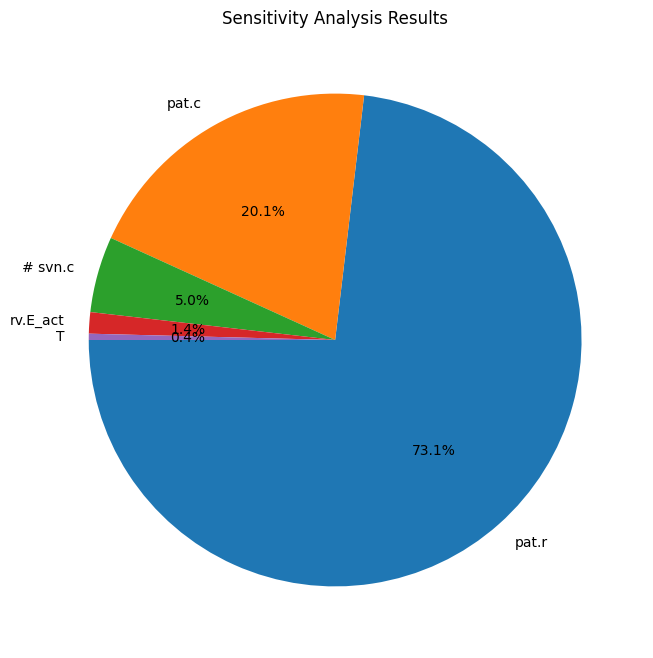

In [21]:
ST = pd.DataFrame(sobol_indices['ST'], index=relevant_columns, columns=['ST'])
ST.sort_values('ST', inplace=True, ascending=False)

labels = ST.index
sizes = ST['ST']

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=180)
plt.title('Sensitivity Analysis Results')
plt.show()